#### Loading Data

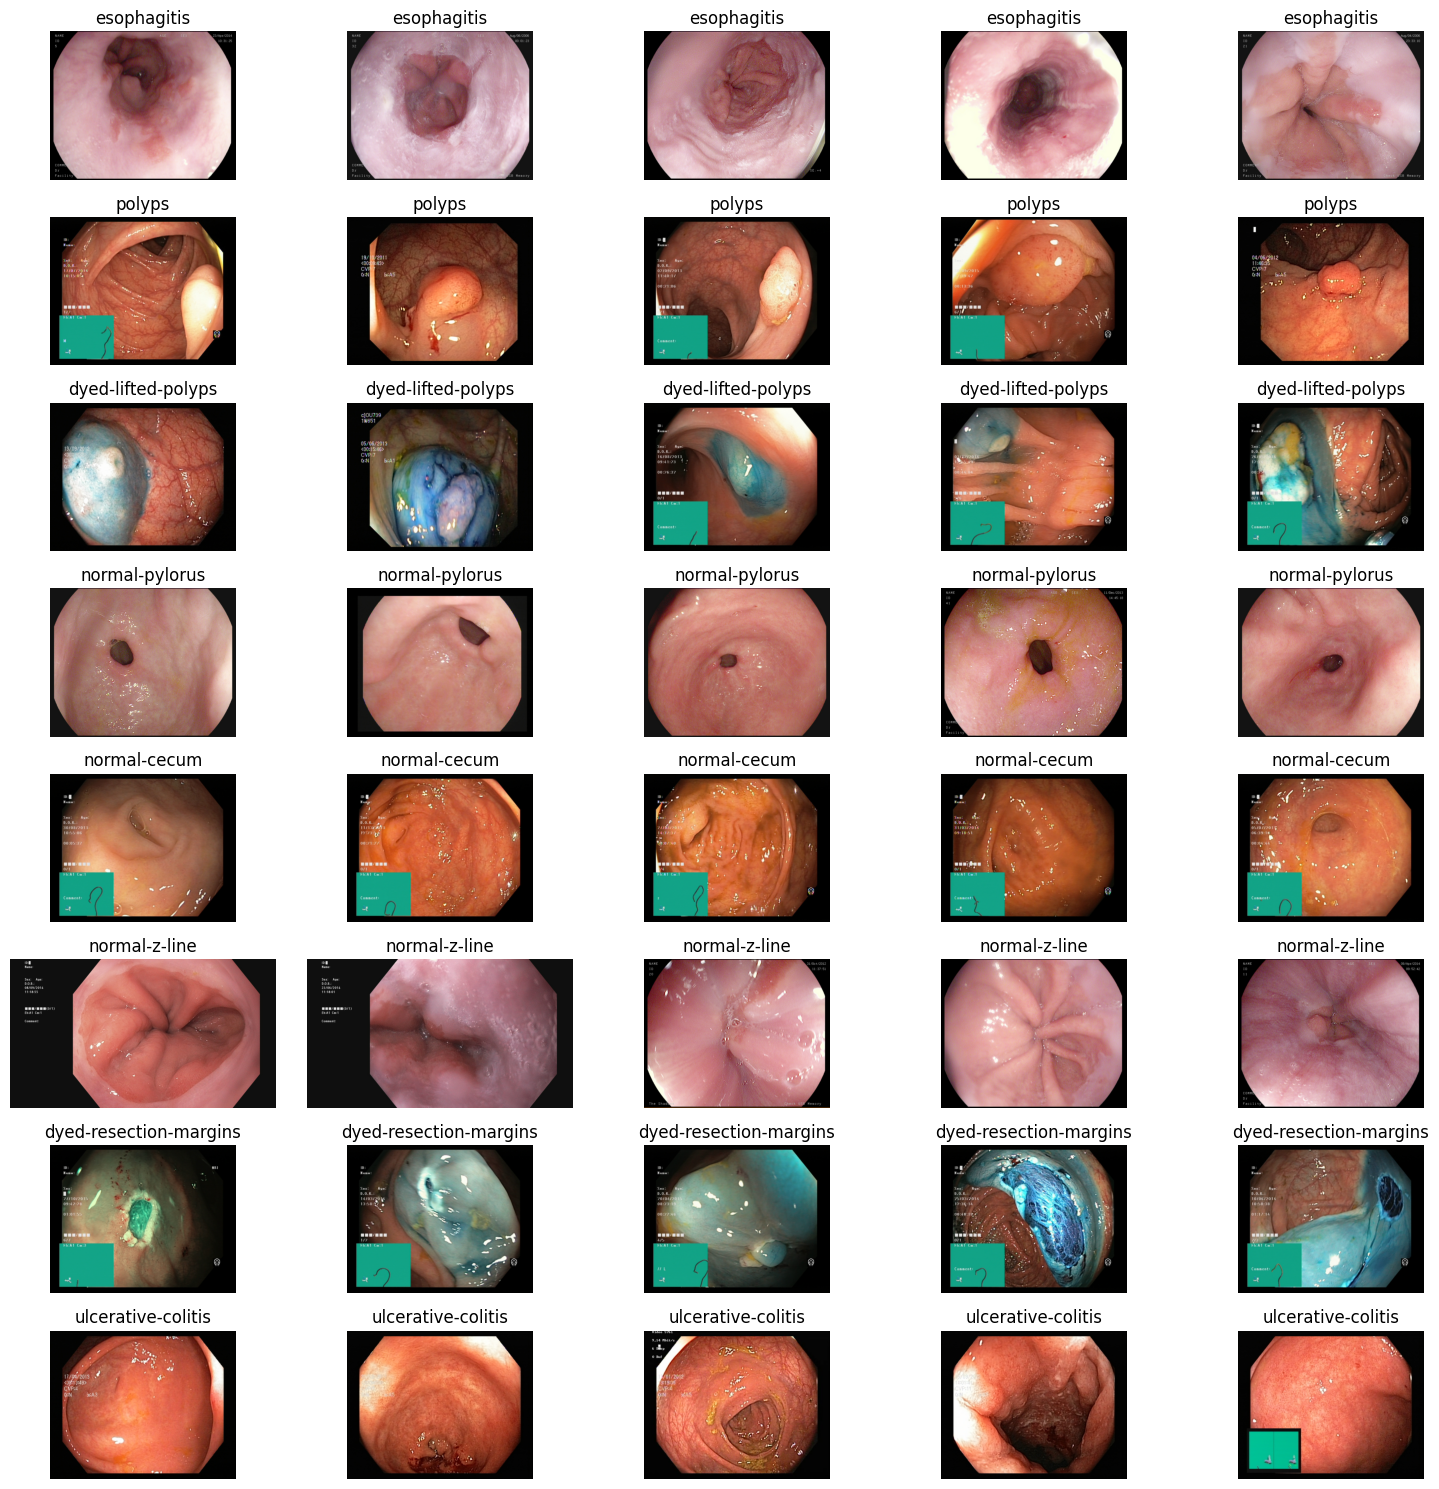

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import random


base_path = '/Users/mac/Documents/ReallyJohn/kvasir-dataset'

# Get only the directories and ignore files like .DS_Store
folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]

fig, axs = plt.subplots(len(folders), 5, figsize=(15, 15))
for i, folder in enumerate(folders):
    imgs = os.listdir(os.path.join(base_path, folder))
    random_imgs = random.sample(imgs, 5)
    for j, img_name in enumerate(random_imgs):
        img_path = os.path.join(base_path, folder, img_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(folder)
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
import os

SAMPLE_SIZE = 100

def load_data(base_path, img_size=(224, 224)):
    # Filtering out non-directory entries
    folders = [folder for folder in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder))]
    
    data, labels = [], []
    
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    for i, folder in enumerate(folders):
        imgs = [img for img in os.listdir(os.path.join(base_path, folder)) if not img.startswith('.')]  # Filtering out hidden/system files like .DS_Store
        # Only load a subset of images
        sampled_imgs = np.random.choice(imgs, min(SAMPLE_SIZE, len(imgs)), replace=False)
        
        for img_name in sampled_imgs:
            img_path = os.path.join(base_path, folder, img_name)
            img = Image.open(img_path)
            img = transform(img)
            data.append(img)
            labels.append(i)
    
    return data, np.array(labels)


base_path = '/Users/mac/Documents/ReallyJohn/kvasir-dataset'
data, labels = load_data(base_path)


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Convert tensors to numpy arrays and adjust shapes
numpy_data = [tensor.cpu().numpy().transpose((1,2,0)) for tensor in data]
numpy_data = np.stack(numpy_data)

# Split data into training and validation
X_train, X_val, y_train, y_val = train_test_split(numpy_data, labels, test_size=0.2, stratify=labels, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# This will generate augmented images on-the-fly while training
train_gen = datagen.flow(X_train, y_train, batch_size=32)


2023-09-09 09:42:11.154476: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
X_train

array([[[[-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         ...,
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ]],

        [[-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         ...,
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ]],

        [[-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         ...,
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ],
         [-0.8509804 , -0.8509804 , -0.8509804 ]],

        ...,

        [[-0.8509804 , -0.8509804 , -0

In [4]:
# Further splitting the validation set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)


#### Model Training

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Initialize the pre-trained ResNet50 model with ImageNet weights
base_model_resnet = ResNet50(weights='imagenet', include_top=False)
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(8, activation='softmax')(x)  # 8 classes in KVASIR dataset
resnet_model = Model(inputs=base_model_resnet.input, outputs=x)



In [6]:
# Initialize the pre-trained DenseNet121 model with ImageNet weights
base_model_densenet = DenseNet121(weights='imagenet', include_top=False)
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(8, activation='softmax')(x)
densenet_model = Model(inputs=base_model_densenet.input, outputs=x)


In [7]:

# Compile the models
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
densenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate adjustment
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)


In [9]:

# Train ResNet model
history_resnet = resnet_model.fit(train_gen, 
                                  validation_data=(X_val, y_val), 
                                  epochs=5, 
                                  callbacks=[early_stopping, reduce_lr])


Epoch 1/5
20/20 [==============================] - 531s 27s/step - loss: 1.5221 - accuracy: 0.5609 - val_loss: 132.1700 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 2/5
20/20 [==============================] - 479s 23s/step - loss: 1.1728 - accuracy: 0.6125 - val_loss: 2030.5582 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 3/5
20/20 [==============================] - 457s 23s/step - loss: 0.8666 - accuracy: 0.6594 - val_loss: 13123.0654 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 4/5
20/20 [==============================] - 440s 22s/step - loss: 0.7061 - accuracy: 0.7422 - val_loss: 7669.0562 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 5/5
20/20 [==============================] - 454s 23s/step - loss: 0.6741 - accuracy: 0.7484 - val_loss: 4.9414 - val_accuracy: 0.1250 - lr: 0.0010


In [10]:
# Train DenseNet model
history_densenet = densenet_model.fit(train_gen, 
                                      validation_data=(X_val, y_val), 
                                      epochs=5, 
                                      callbacks=[early_stopping, reduce_lr])

Epoch 1/5
20/20 [==============================] - 641s 28s/step - loss: 0.9958 - accuracy: 0.6328 - val_loss: 18.9457 - val_accuracy: 0.1875 - lr: 0.0010
Epoch 2/5
20/20 [==============================] - 628s 31s/step - loss: 0.6819 - accuracy: 0.7469 - val_loss: 104.2427 - val_accuracy: 0.1250 - lr: 0.0010
Epoch 3/5
20/20 [==============================] - 634s 32s/step - loss: 0.5647 - accuracy: 0.7922 - val_loss: 22.5313 - val_accuracy: 0.2625 - lr: 0.0010
Epoch 4/5
20/20 [==============================] - 1009s 52s/step - loss: 0.4736 - accuracy: 0.8078 - val_loss: 3.1255 - val_accuracy: 0.4875 - lr: 0.0010
Epoch 5/5
20/20 [==============================] - 669s 33s/step - loss: 0.3665 - accuracy: 0.8594 - val_loss: 6.4627 - val_accuracy: 0.3875 - lr: 0.0010


In [67]:
import netron
import tensorflow as tf

# Save the models first
resnet_model.save("resnet_model.h5")
densenet_model.save("densenet_model.h5")

# Start the Netron server
# It will start a local server and automatically open a web page displaying the model.
netron.start("resnet_model.h5")  # This will display the ResNet model.
netron.start("densenet_model.h5")  # This will display the DenseNet model.


Serving 'resnet_model.h5' at http://localhost:17004
Serving 'densenet_model.h5' at http://localhost:24608


('localhost', 24608)

#### Implement Saliency Map

In [41]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt






# Grad-CAM Function
def grad_cam(model, image, cls, layer_name):
    # Convert the model to a function so we can get intermediate outputs
    intermediate_layer_model = tf.keras.models.Model(inputs=model.input, 
                                                     outputs=[model.get_layer(layer_name).output, model.output])

    # Use GradientTape to monitor the computation for which we want gradients
    with tf.GradientTape() as tape:
        tape.watch(image)
        conv_output, predictions = intermediate_layer_model(image)
        loss = predictions[:, cls]

    # Compute the gradients of the loss with respect to the layer's output
    grads = tape.gradient(loss, conv_output)

    # Compute the pooled gradients and the Grad-CAM heatmap
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(pooled_grads * conv_output, axis=-1)[0]
    heatmap = tf.nn.relu(heatmap)
    
    # Normalize the heatmap
    heatmap /= tf.math.reduce_max(heatmap)
    heatmap = tf.expand_dims(heatmap, axis=-1)
    heatmap = tf.image.resize(heatmap, (224, 224)).numpy()
    
    # Ensure the heatmap is 2D
    heatmap = heatmap.squeeze()

    return heatmap






# Visualization
def plot_cam(images, labels, models, model_names, layer_names):
    fig, axs = plt.subplots(len(images), len(models)+1, figsize=(15, 15))

    for i, image in enumerate(images):
        axs[i, 0].imshow(image)
        axs[i, 0].set_title("Original - " + str(labels[i]))
        axs[i, 0].axis('off')

        for j, model in enumerate(models):
            tensor_image = tf.convert_to_tensor(np.expand_dims(image, axis=0))
            cam = grad_cam(model, tensor_image, labels[i], layer_names[j])
            axs[i, j+1].imshow(image, alpha=0.6)
            axs[i, j+1].imshow(cam, cmap='jet', alpha=0.4)
            axs[i, j+1].set_title(model_names[j] + " CAM - " + str(labels[i]))
            axs[i, j+1].axis('off')
    
    plt.tight_layout()
    plt.show()



In [42]:

# Select a few random images from the test set
num_samples = 3
random_indices = np.random.choice(X_test.shape[0], num_samples, replace=False)
sample_images = X_test[random_indices]
sample_labels = y_test[random_indices]


In [43]:

# Grad-CAM Visualization
model_names = ["ResNet", "DenseNet"]
layer_names = ["conv5_block3_out", "conv5_block16_2_conv"]  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/mac

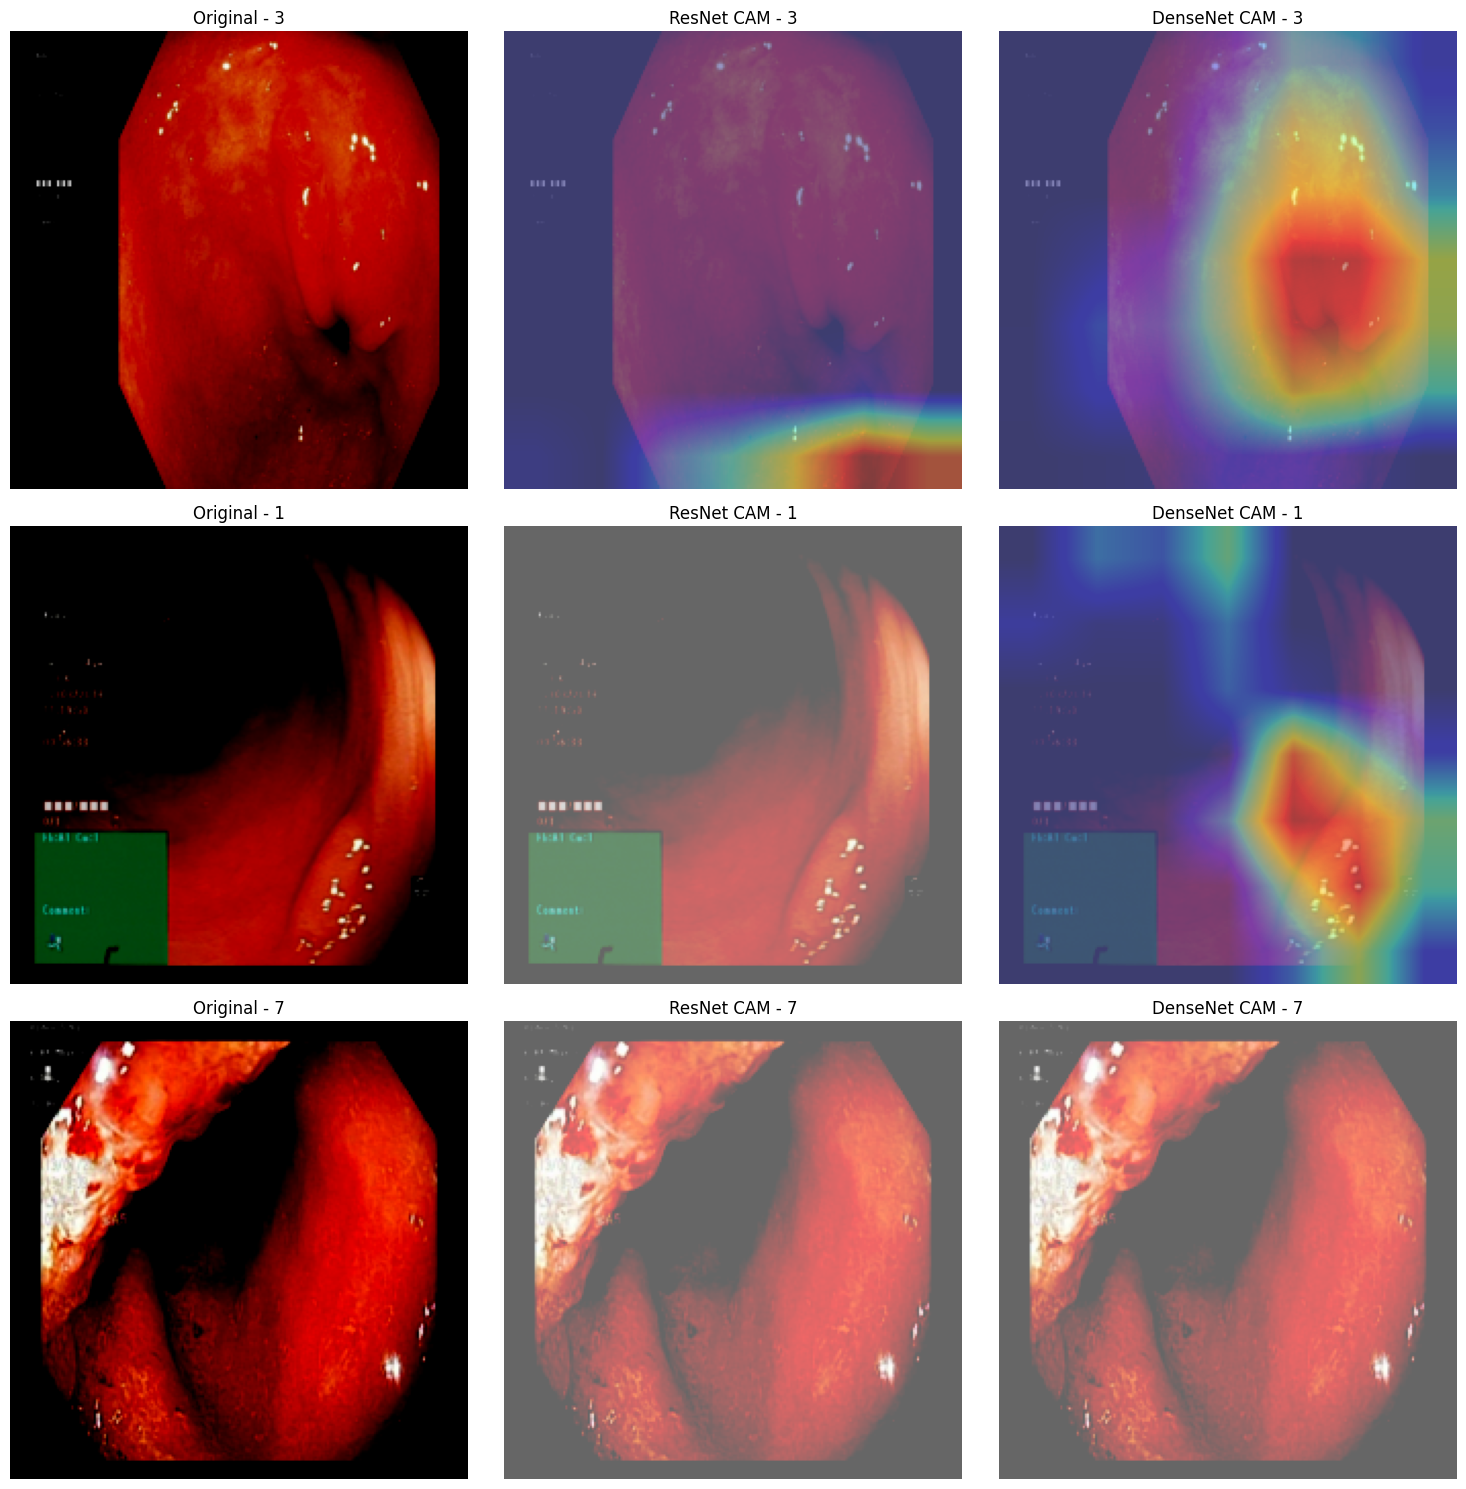

In [44]:


plot_cam(sample_images, sample_labels, [resnet_model, densenet_model], model_names, layer_names)

# Model Evaluation
resnet_score = resnet_model.evaluate(X_test, y_test, verbose=0)
densenet_score = densenet_model.evaluate(X_test, y_test, verbose=0)


In [50]:
print(f"ResNet Accuracy: {resnet_score[1]*100:.2f}%")
print(f"DenseNet Accuracy: {densenet_score[1]*100:.2f}%")



ResNet Accuracy: 75.50%
DenseNet Accuracy: 86.50%


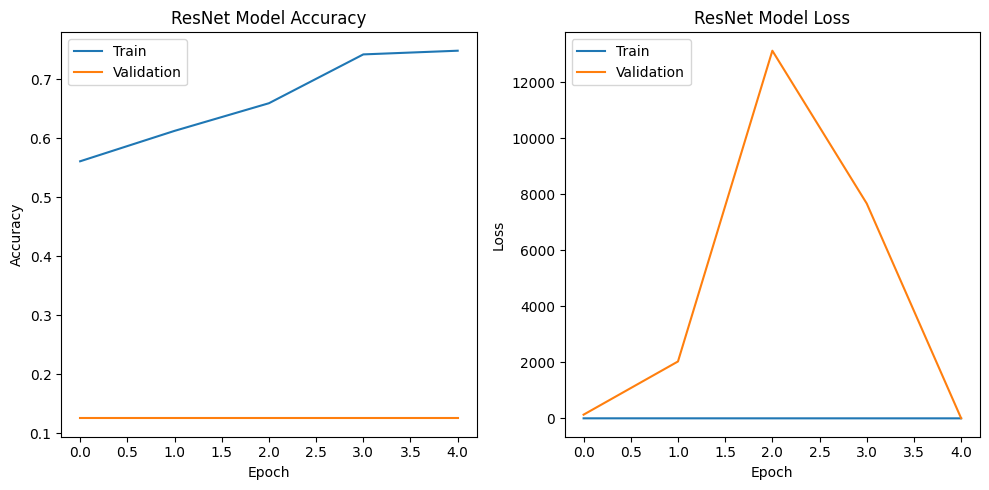

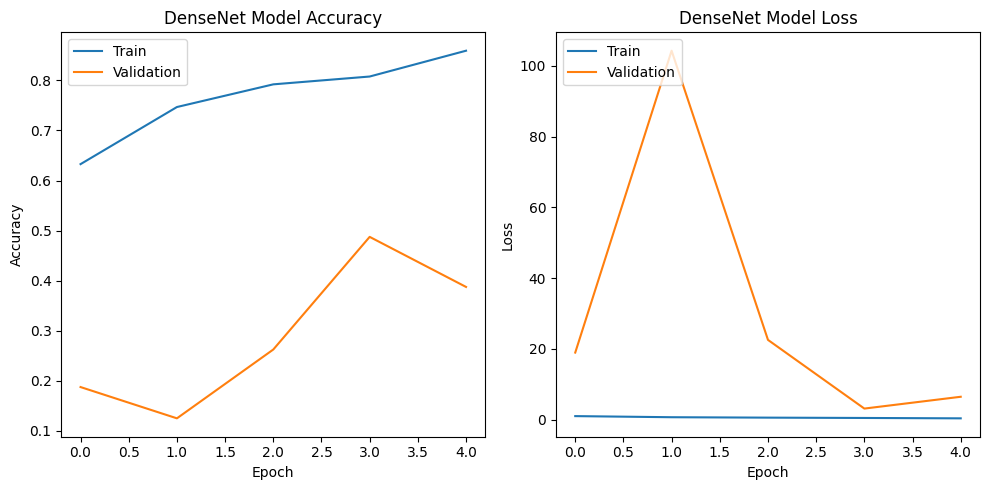

In [48]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    # summarize history for accuracy
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title + ' Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title + ' Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_history(history_resnet, "ResNet")
plot_history(history_densenet, "DenseNet")


In [52]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Get the model's predictions
y_pred_resnet = resnet_model.predict(X_test)
y_pred_densenet = densenet_model.predict(X_test)

# Ensure y_test is in one-hot encoded format. 
if y_test.ndim == 1:
    y_test_onehot = np.eye(8)[y_test]
else:
    y_test_onehot = y_test

# Calculate ROC AUC for each class
roc_auc_resnet = [roc_auc_score(y_test_onehot[:, i], y_pred_resnet[:, i]) for i in range(8)]
roc_auc_densenet = [roc_auc_score(y_test_onehot[:, i], y_pred_densenet[:, i]) for i in range(8)]

# Average AUCs
avg_roc_auc_resnet = np.mean(roc_auc_resnet)
avg_roc_auc_densenet = np.mean(roc_auc_densenet)

print(f"Average ROC AUC for ResNet: {avg_roc_auc_resnet:.4f}")
print(f"Average ROC AUC for DenseNet: {avg_roc_auc_densenet:.4f}")


Average ROC AUC for ResNet: 0.8583
Average ROC AUC for DenseNet: 0.9216
